In [1]:
# data_dir = '../csv_output_with_phases'  # Replace with your directory
data_dir = './csv_output_with_phases'

In [2]:
#############################################################
# 1. Load data and define a dataframe with new column names #
#############################################################
import os
import pandas as pd
import numpy as np

# Load data and define a dataframe with new column names 
def load_data_from_files(data_dir):
    all_data = []  
    # iterate over all file names in the directory 
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            # Extract metadata from the filename ( Filename format: collectionID_stepInfo_otherInfo.csv )
            collection_id, step_info, _ = filename.split('_', 2)
            
            # Define steps from the file name
            step_number = ''.join(filter(str.isdigit, step_info))
            foot = 'R' if 'R' in step_info else 'L'
            
            # Construct the full file path and read the CSV file into a DataFrame
            filepath = os.path.join(data_dir, filename)
            df = pd.read_csv(filepath)

            # Define column names
            df['collection_id'] = collection_id + '_' + str(step_number) + '_' + foot
            df['time'] = pd.to_datetime(df['time'])
            df['elapsed_time'] = (df['time'] - df['time'].min()).dt.total_seconds()
            
            # Define the columns to keep in the DataFrame
            cols = ['collection_id', 'elapsed_time', 'gyroscope_x', 'gyroscope_y',
                    'gyroscope_z', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'phase']
            df = df[cols]
            
            # Append the processed DataFrame to the list
            all_data.append(df)
    
    data = pd.concat(all_data, ignore_index=True)

    return data

In [3]:
######################################################
# 2. Preprocess data                                 #
######################################################
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(data, features, target):
    # Drop rows with missing values
    data = data.dropna(subset=features + target)

    # Drop rows where any target column is 0
    data = data[(data[target] != 0).all(axis=1)]

    # Subtract 1 from target column 
    # XGBoost takes values from 0 ~ (num_class-1), and the current phase starts from 1
    data[target] = data[target] - 1

    # Normalize features
    scaler = MinMaxScaler()
    data.loc[:, features] = scaler.fit_transform(data[features])

    return data


In [4]:
######################################################
# 3. Compute the lag size using ACF                  #
######################################################
from statsmodels.tsa.stattools import acf
from joblib import Parallel, delayed
import numpy as np

def compute_cutoff_lag(target, nlags=50):
    # get acf and confidence interval values
    acf_values, confint = acf(target, alpha=0.05, nlags=nlags)
    
    # compute confidential interval
    lower_bound = confint[1:, 0] - acf_values[1:]
    upper_bound = confint[1:, 1] - acf_values[1:]
    
    # Compute cutoff values 
    cutoff_lag = np.where((acf_values[1:] < lower_bound) | (acf_values[1:] > upper_bound))[0]
    if len(cutoff_lag) > 0:
        return cutoff_lag[-1] + 1  # Adjust index to match lag
    return 0

def get_lag_size(data, nlags=50):
    collection_ids = data['collection_id'].unique()

    # Compute cut_off lags for each collection id in parallel
    cutoff_lags = Parallel(n_jobs=-1)(
        delayed(compute_cutoff_lag)(
            data[data['collection_id'] == collection_id]['phase'], nlags
        ) for collection_id in collection_ids
    )

    lag_size = round(np.mean(cutoff_lags))
    return lag_size

In [201]:
######################################################
# 4. Define Lagged DataSet                           #
######################################################
import pandas as pd
import numpy as np

class Lagged_Dataset():
    def __init__(self, data, features, target, lag_size=30):
        self.data = data
        self.original_features = features
        self.target = target
        self.lag_size = lag_size 
        self.lagged_feature_names = None
        
        self.X_df = pd.DataFrame()
        self.y_df = pd.DataFrame()
        self.collection_ids_df = pd.DataFrame()
        
        self.X = None
        self.y = None
        self.collection_ids = None
        
        self.make_dataset()
    
    def make_dataset(self):
        intermediate_X_df = pd.DataFrame()
        intermediate_y_df = pd.DataFrame()
        intermediate_collection_ids_df = pd.DataFrame()
        len_features = len(self.original_features) 
        collection_ids = self.data['collection_id'].unique()
        
        # Define lagged dataset for each collection id and concatenate them in order 
        for collection_id in collection_ids:
            cur_collection_row_idx = self.data['collection_id'] == collection_id 
            cur_collection_data = self.data[cur_collection_row_idx].sort_values(by='elapsed_time')
            cur_collection_data = cur_collection_data[self.original_features + self.target + ['collection_id']] # reorder the columns 
            cur_collection_data_length = len(cur_collection_data)
            
            # Make lagged dataset
            if cur_collection_data_length > self.lag_size:
                lagged_features = {} 
                for j in range(len_features):
                    for i in range(1, self.lag_size+1): 
                        lagged_features[f'{self.original_features[j]}_lag{i}'] = cur_collection_data[self.original_features[j]].shift(i)
                lagged_df = pd.DataFrame(lagged_features) 
                cur_collection_data = pd.concat([cur_collection_data, lagged_df], axis=1)
                # Define lagged feature names
                if self.lagged_feature_names is None:
                    self.lagged_feature_names = list(lagged_df.columns) 
            
            # Drop na values and drop original features
            cur_collection_data.dropna(inplace=True)
            # Keep the index consistency
            cur_collection_data.reset_index(drop=True, inplace=True)
            # Drop original features
            cur_collection_data.drop(columns=self.original_features)
            # Add collection id
            cur_collection_data['collection_id'] = collection_id 
            
            # Concatenate lagged dataset and reset index to keep the order of the data
            intermediate_X_df = pd.concat([intermediate_X_df, cur_collection_data[self.lagged_feature_names]], ignore_index=True)
            intermediate_y_df = pd.concat([intermediate_y_df, cur_collection_data[self.target]], ignore_index=True)
            intermediate_collection_ids_df = pd.concat([intermediate_collection_ids_df, cur_collection_data[['collection_id']]], ignore_index=True)
            
        self.X_df = intermediate_X_df
        self.y_df = intermediate_y_df
        self.collection_ids_df = intermediate_collection_ids_df 
        
        # final values to use
        self.X = self.X_df.values
        self.y = self.y_df.values
        self.collection_ids = self.collection_ids_df.values
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.collection_ids[idx]
            
    def __len__(self):
        return len(self.X)

In [6]:
######################################################
# 5. Split Train, Validation, Test Sets              #
######################################################
from sklearn.model_selection import GroupShuffleSplit 

def split_test_train_by_collection_id(X, y, collection_ids, test_size=0.2):    
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups=collection_ids)) 
    
    X_train, y_train, train_col_ids = X[train_idx], y[train_idx], collection_ids[train_idx]
    X_test, y_test, test_col_ids = X[test_idx], y[test_idx], collection_ids[test_idx]
    
    return X_train, y_train, train_col_ids, X_test, y_test, test_col_ids

In [7]:
######################################################
# 6. Tuning Hyper Parameters                         #
######################################################
from sklearn.metrics import accuracy_score
from optuna.samplers import TPESampler
import numpy as np
import optuna
import copy 

def objective_function(trial, X_train, y_train, X_val, y_val, base_model):
    clf = copy.deepcopy(base_model)
    
    # Define hyperparameters to be tuned 
    params = {
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float ('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
    }
    
    clf.set_params(**params)
    clf.fit(
        X_train, y_train.ravel(),
        eval_set=[(X_train, y_train.ravel()), (X_val, y_val.ravel())],
        verbose=False
    )
    
    y_pred = clf.predict(X_val) # Metrics to optimize ( Change the metric to optimize to your need )
    
    # Calculate metrics 
    validation_accuracy = accuracy_score(y_val, y_pred)
    
    train_log_loss_curve = clf.evals_result_['validation_0']['mlogloss']
    val_log_loss_curve = clf.evals_result_['validation_1']['mlogloss'] 
    
    trial.set_user_attr("val_accuracy", validation_accuracy)
    trial.set_user_attr("train_log_loss_curve", train_log_loss_curve)
    trial.set_user_attr("val_log_loss_curve", val_log_loss_curve) 
    
    return validation_accuracy 


def optimize_hyperparameter(X_train, y_train, X_val, y_val, base_model, n_trials=5):
    # Define sampler
    sampler = TPESampler(seed=42)
    # Create study instance
    study = optuna.create_study(direction='maximize', sampler=sampler)
    # Find hyperparameters 
    study.optimize(
        lambda trial: objective_function(
            trial, X_train, y_train, X_val, y_val, base_model
        ),
        n_trials=n_trials
    )
    
    return study
    

In [8]:
def save_study(study, dir='./study', prefix=''):
    if not os.path.exists(dir):
        os.makedirs(dir)
    joblib.dump(study, os.path.join(dir, prefix + 'study.pkl'))
    print(f"Study saved to {os.path.join(dir, prefix + 'study.pkl')}")
    
def load_study(dir='./study', prefix=''):
    return joblib.load(os.path.join(dir, prefix + 'study.pkl'))

In [9]:
######################################################
# 7. Train and save the Final Model                  #
######################################################
import joblib

def train_final_model(best_trial, X_train, y_train, base_model):
    clf = copy.deepcopy(base_model)
    
    # Remove early_stopping_rounds from best_params, because val_set is required for early stopping but val_set is not used for the final training.
    best_params = {k: v for k, v in best_trial.params.items() if k != 'early_stopping_rounds'}
    
    clf.set_params(**best_params)
    clf.fit(X_train, y_train)
    
    return clf 


def save_final_model(model, dir='./final_model', prefix=''):
    if not os.path.exists(dir):
        os.makedirs(dir)
    joblib.dump(model, os.path.join(dir, prefix + 'xgb_clf.pkl'))
    print(f"Final model saved to {os.path.join(dir, prefix + 'xgb_clf.pkl')}")

In [10]:
######################################################
# 8. Load and test the final model on all groups     #
######################################################
from sklearn.metrics import classification_report

def load_final_model(dir='./final_model', prefix=''):
    return joblib.load(os.path.join(dir, prefix + 'xgb_clf.pkl'))

def test_final_model(final_clf, X_test, y_test):
    # Compute the accuracy on the test set 
    y_pred = final_clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'test accuracy: {test_accuracy:.6f}')

    print('-------------------------------------------------------')

    # Report the classification result 
    labels = range(len(np.unique(y_test)))
    class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']
    classification_report_result = classification_report(y_test, y_pred, labels=labels, target_names=class_names)
    print(classification_report_result)

In [11]:
#########################################################
# 9. Load and test the final model on individual groups #
#########################################################
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
import os

def load_final_model(dir='./final_model', prefix=''):
    return joblib.load(os.path.join(dir, prefix + 'xgb_clf.pkl'))

# Parse classification report and convert it to a dataframe
def convert_classification_reports_to_df(reports):
    rows = []
    for report in reports:
        collection_id = report['id']
        for label, metrics in report['result'].items():
            if label in ['accuracy', 'macro avg', 'weighted avg']:
                continue
            row = {'collection_id': collection_id, 'label': label}
            row.update(metrics)
            rows.append(row)
    return pd.DataFrame(rows)


# Test model per each collection id and save the classification report 
def test_final_model_per_collection_id(final_clf, X_test, y_test, collection_ids_test, dir='./report', prefix=''):
    current_path = os.getcwd()
    report_path = os.path.join(current_path, 'report')
    os.makedirs(report_path, exist_ok=True)

    accuracy_results = {}
    classification_reports = []
    class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']
    collection_ids_test = collection_ids_test.ravel()  # Flatten for proper indexing
    
    for collection_id in np.unique(collection_ids_test):
        # Get the rows corresponding to the current collection id
        mask = collection_ids_test == collection_id 
        X_test_collection = X_test[mask, :]
        y_test_collection = y_test[mask].ravel()

        # Get predictions
        y_pred_collection = final_clf.predict(X_test_collection)
        accuracy = accuracy_score(y_test_collection, y_pred_collection)
        accuracy_results[collection_id] = accuracy

        # Get classification report 
        unique_labels = np.unique(y_test_collection)
        report = classification_report(
            y_test_collection, y_pred_collection, 
            labels=unique_labels, 
            target_names=[class_names[i] for i in unique_labels], 
            output_dict=True, zero_division=0
        )
        
        classification_report_dict = {'id': collection_id, 'result': report}
        classification_reports.append(classification_report_dict)
    
    # Dataframe containing accuracy scores for each collection id 
    accuracy_results_df = pd.DataFrame(list(accuracy_results.items()), columns=['collection_id', 'accuracy'])
    # Count the number of class instances per each collection id 
    accuracy_results_df['data_size'] = accuracy_results_df['collection_id'].apply(lambda x: len(X_test[collection_ids_test == x, :]))
    accuracy_results_df['n_heel_strike'] = accuracy_results_df['collection_id'].apply(lambda x: len(y_test[(collection_ids_test == x) & (y_test.ravel() == 0)]))
    accuracy_results_df['n_foot_flat'] = accuracy_results_df['collection_id'].apply(lambda x: len(y_test[(collection_ids_test == x) & (y_test.ravel() == 1)]))
    accuracy_results_df['n_heel_off'] = accuracy_results_df['collection_id'].apply(lambda x: len(y_test[(collection_ids_test == x) & (y_test.ravel() == 2)]))
    accuracy_results_df['n_toe_off'] = accuracy_results_df['collection_id'].apply(lambda x: len(y_test[(collection_ids_test == x) & (y_test.ravel() == 3)]))
    
    # Parse and convert classification reports to a dataframe
    classification_reports_df = convert_classification_reports_to_df(classification_reports)
    # Merge the classification report dataframe and accuracy score dataframe
    final_report = accuracy_results_df.merge(classification_reports_df, on='collection_id', how='left')
    
    # Save the merged dataframe 
    if not os.path.exists(dir):
        os.makedirs(dir)
    save_path = os.path.join(dir, prefix + 'gait_event_detection_report.csv')
    final_report.to_csv(save_path, index=False)
    print(f'Final reports saved to {save_path}')

    return final_report


In [194]:
#######################################################################
# 10. Plot Training Progress Analysis Plots                           #
#######################################################################
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import optuna


# Train-Validation Loss Curve Plot
def plot_loss_curves(best_trial, ax=None):
    # Retrieve loss data stored in the trial
    train_loss = best_trial.user_attrs["train_log_loss_curve"]
    val_loss = best_trial.user_attrs["val_log_loss_curve"]
    epochs = range(1, len(train_loss) + 1)

    # Create a new Figure if ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Plot Train Loss & Validation Loss
    ax.plot(epochs, train_loss, label='Train Loss', color='blue', linewidth=2)
    ax.plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2)

    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Train-Validation Loss Curve', fontsize=12)
    ax.legend()
    ax.grid(True)

    # Show plt if executed individually
    if ax is None:
        plt.show()


# Optuna Optimization History Plot 
def plot_optimization_history(study, ax=None):
    trials = study.trials
    trial_numbers = [t.number for t in trials if t.state == optuna.trial.TrialState.COMPLETE]
    values = [t.value for t in trials if t.state == optuna.trial.TrialState.COMPLETE]

    # Calculate the path maintaining the best performance
    best_values = []
    best_so_far = float('-inf')
    for v in values:
        best_so_far = max(best_so_far, v)
        best_values.append(best_so_far)

    # Create a new Figure if ax is None
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Original optimization path
    ax.plot(trial_numbers, values, marker='o', markersize=4, linestyle='-', color='blue', label="Validation Accuracy", alpha=0.6)

    # Best performance path
    ax.plot(trial_numbers, best_values, linestyle='--', color='red', label="Best So Far", linewidth=1.5)

    ax.set_xlabel('Trial Number', fontsize=10)
    ax.set_ylabel('Validation Accuracy', fontsize=10)
    ax.set_title('Optimization History', fontsize=12)
    ax.grid(True)
    ax.legend()

    # Show Figure if executed individually
    if ax is None:
        plt.show()
        
        
# Optuna Hyperparameter Importance Plot
def plot_hyperparameter_importance(study, ax=None):
    # Calculate importance
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    values = list(importance.values())

    # Create a new Figure if ax is None
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bar chart
    ax.barh(params, values, color='royalblue')

    ax.set_xlabel('Importance', fontsize=12)
    ax.set_ylabel('Hyperparameter', fontsize=12)
    ax.set_title('Hyperparameter Importance', fontsize=12)
    ax.invert_yaxis()  # Sort for better viewing in order of importance

    # Show Figure if executed individually
    if ax is None:
        plt.show()


def plot_all(best_trial, study):
    # Create the entire Figure (increase size)
    fig = plt.figure(figsize=(10, 6))  

    # Set GridSpec (2 rows, 2 columns, set height ratios)
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

    # First row (Train-Validation Loss Curve) - occupies both columns
    ax1 = fig.add_subplot(gs[0, :])
    plot_loss_curves(best_trial, ax=ax1)  # Modify to draw directly on ax
    ax1.set_title("Train-Validation Loss Curve", fontsize=16)

    # Second row, first column (Optimization History)
    ax2 = fig.add_subplot(gs[1, 0])
    plot_optimization_history(study, ax=ax2)  # Modify to draw directly on ax

    # Second row, second column (Hyperparameter Importance)
    ax3 = fig.add_subplot(gs[1, 1])
    plot_hyperparameter_importance(study, ax=ax3)  # Modify to draw directly on ax

    plt.tight_layout()
    plt.show()


---

In [15]:
prefix = 'final_'

In [16]:
## 1. Load data and define a dataframe with new column names #
data = load_data_from_files(data_dir)

# Define Features and Target 
features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
            'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
target = ['phase']

data.head()


,collection_id,elapsed_time,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,phase
0,vh92aaJeQLxDazem2hN5_6_L,0.000,168.63,-158.62,-113.82,-1.026752,2.276032,-8.625400,1
1,vh92aaJeQLxDazem2hN5_6_L,0.005,-71.89,-272.58,-129.92,-2.516616,-1.586000,-2.127680,1
2,vh92aaJeQLxDazem2hN5_6_L,0.010,-129.85,-334.53,-114.10,-0.890112,-0.234240,0.258640,1
3,vh92aaJeQLxDazem2hN5_6_L,0.015,-206.85,-334.60,-111.30,-0.842288,0.425048,-1.624064,1
4,vh92aaJeQLxDazem2hN5_6_L,0.020,-223.65,-354.62,-105.70,0.108824,0.293288,-1.969568,1


In [17]:
## 2. Preprocess data                                
preprocessed_data = preprocess_data(data, features, target)
preprocessed_data.head()

,collection_id,elapsed_time,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,phase
0,vh92aaJeQLxDazem2hN5_6_L,0.000,0.691635,0.489820,0.233674,0.414113,0.588787,0.219917,0
1,vh92aaJeQLxDazem2hN5_6_L,0.005,0.498991,0.405266,0.212696,0.335429,0.371178,0.471328,0
2,vh92aaJeQLxDazem2hN5_6_L,0.010,0.452568,0.359302,0.233309,0.421329,0.447344,0.563660,0
3,vh92aaJeQLxDazem2hN5_6_L,0.015,0.390895,0.359250,0.236957,0.423855,0.484492,0.490814,0
4,vh92aaJeQLxDazem2hN5_6_L,0.020,0.377439,0.344396,0.244254,0.474086,0.477068,0.477446,0


In [18]:
## 3. Compute the lag size using ACF                 
lag_size = get_lag_size(preprocessed_data)
lag_size

19

In [203]:
## 4. Define Lagged DataSet                           
lagged_dataset = Lagged_Dataset(preprocessed_data, features, target, lag_size=lag_size)

In [202]:
lagged_dataset.collection_ids_df

,0
0,vh92aaJeQLxDazem2hN5_6_L
1,vh92aaJeQLxDazem2hN5_6_L
2,vh92aaJeQLxDazem2hN5_6_L
3,vh92aaJeQLxDazem2hN5_6_L
4,vh92aaJeQLxDazem2hN5_6_L
...,...
462479,rbk3m0CFK4mQVt2ot6T2_6_R
462480,rbk3m0CFK4mQVt2ot6T2_6_R
462481,rbk3m0CFK4mQVt2ot6T2_6_R
462482,rbk3m0CFK4mQVt2ot6T2_6_R


In [20]:
pd.concat([lagged_dataset.X_df, lagged_dataset.y_df, lagged_dataset.collection_ids_df], axis=1).head()

,gyroscope_x_lag1,gyroscope_x_lag2,gyroscope_x_lag3,gyroscope_x_lag4,gyroscope_x_lag5,gyroscope_x_lag6,gyroscope_x_lag7,gyroscope_x_lag8,gyroscope_x_lag9,gyroscope_x_lag10,...,accelerometer_z_lag12,accelerometer_z_lag13,accelerometer_z_lag14,accelerometer_z_lag15,accelerometer_z_lag16,accelerometer_z_lag17,accelerometer_z_lag18,accelerometer_z_lag19,phase,0
0,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,0.560327,0.565317,0.559094,...,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660,0.471328,0.219917,1,vh92aaJeQLxDazem2hN5_6_L
1,0.568569,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,0.560327,0.565317,...,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660,0.471328,1,vh92aaJeQLxDazem2hN5_6_L
2,0.565710,0.568569,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,0.560327,...,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660,1,vh92aaJeQLxDazem2hN5_6_L
3,0.565429,0.565710,0.568569,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,...,0.467684,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,1,vh92aaJeQLxDazem2hN5_6_L
4,0.564701,0.565429,0.565710,0.568569,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,...,0.467835,0.467684,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,1,vh92aaJeQLxDazem2hN5_6_L


In [21]:
## 5. Split Train, Validation, Test Sets              
X_train, y_train, train_collection_ids, X_test, y_test, test_collection_ids = split_test_train_by_collection_id(lagged_dataset.X, lagged_dataset.y, lagged_dataset.collection_ids)
X_train_tuning, y_train_tuning, _, X_val_tuning, y_val_tuning, _ = split_test_train_by_collection_id(X_train, y_train, train_collection_ids, test_size=0.25)

In [22]:
## 6. Tuning Hyper Parameters                         
from xgboost import XGBClassifier

# Define a base model 
base_model = XGBClassifier(
        random_state=42, 
        objective='multi:softmax',
        eval_metric='mlogloss',
        n_jobs=-1,
        enable_categorical=True,
    ) 

study = optimize_hyperparameter(X_train_tuning, y_train_tuning, X_val_tuning, y_val_tuning, base_model, n_trials=50)

[I 2025-03-02 21:03:52,294] A new study created in memory with name: no-name-468f7188-9ad8-4a2f-b8fc-7f2ded269662
[I 2025-03-02 21:04:15,328] Trial 0 finished with value: 0.9119251541105231 and parameters: {'early_stopping_rounds': 81, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'n_estimators': 340, 'min_child_weight': 2, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'gamma': 4.330880728874676}. Best is trial 0 with value: 0.9119251541105231.
[I 2025-03-02 21:05:41,629] Trial 1 finished with value: 0.9120751732038623 and parameters: {'early_stopping_rounds': 124, 'max_depth': 8, 'learning_rate': 0.01596950334578271, 'n_estimators': 488, 'min_child_weight': 9, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 0.9170225492671691}. Best is trial 1 with value: 0.9120751732038623.
[I 2025-03-02 21:06:18,312] Trial 2 finished with value: 0.912211554197807 and parameters: {'early_stopping_rounds': 68, 'max_depth': 7, 'learn

In [23]:
save_study(study, prefix=prefix)
study = load_study(prefix=prefix)

Study saved to ./study/final_study.pkl


In [24]:
best_trial = study.best_trial
best_params = best_trial.params
best_score = best_trial.value

In [25]:
## 7. Train and save the Final Model                  
final_clf = train_final_model(best_trial, X_train, y_train, base_model)
save_final_model(final_clf, prefix=prefix)

Final model saved to ./final_model/final_xgb_clf.pkl


In [26]:
## 8. Load and test the final model on all groups     
final_clf = load_final_model()
test_final_model(final_clf, X_test, y_test)

test accuracy: 0.921006
-------------------------------------------------------
              precision    recall  f1-score   support

 heel strike       0.71      0.53      0.61      1417
   foot flat       0.91      0.94      0.93     33777
    heel off       0.86      0.81      0.83     19754
     toe off       0.97      0.97      0.97     37920

    accuracy                           0.92     92868
   macro avg       0.86      0.82      0.84     92868
weighted avg       0.92      0.92      0.92     92868



In [205]:
## 9. Load and test the final model on individual groups
final_clf = load_final_model(prefix=prefix)
final_report = test_final_model_per_collection_id(final_clf, X_test, y_test, test_collection_ids, prefix=prefix)
final_report.set_index(["collection_id", "accuracy", "data_size", "n_heel_strike", "n_foot_flat", "n_heel_off", "n_toe_off", "label"])

Final reports saved to ./report/final_gait_event_detection_report.csv


precision  \
collection_id             accuracy data_size n_heel_strike n_foot_flat n_heel_off n_toe_off label                    
0373xrf1eaJoc8IcE6Gc_7_R  0.971831 213       0             77          52         84        foot flat     0.962500   
                                                                                            heel off      1.000000   
                                                                                            toe off       0.965517   
04SwmTFshylAIDUNCYTh_12_R 0.748899 227       0             135         12         80        foot flat     1.000000   
                                                                                            heel off      0.075472   
...                                                                                                            ...   
zmCkqhYTl03DYdauXAtc_7_R  0.941463 205       7             82          32         84        toe off       1.000000   
zmCkqhYTl03DYdauXAtc_8_L  0.850000 200       2             57          64         77        heel strike   0.500000   
                                                                                            foot flat     0.670732   
                                                                                            heel off      1.000000   
                                                                                            toe off       0.987179   

                                                                                                           recall  \
collection_id             accuracy data_size n_heel_strike n_foot_flat n_heel_off n_toe_off label                   
0373xrf1eaJoc8IcE6Gc_7_R  0.971831 213       0             77          52         84        foot flat    1.000000   
                                                                                            heel off     0.884615   
                                                                                            toe off      1.000000   
04SwmTFshylAIDUNCYTh_12_R 0.748899 227       0             135         12         80        foot flat    0.637037   
                                                                                            heel off     0.333333   
...                                                                                                           ...   
zmCkqhYTl03DYdauXAtc_7_R  0.941463 205       7             82          32         84        toe off      0.964286   
zmCkqhYTl03DYdauXAtc_8_L  0.850000 200       2             57          64         77        heel strike  1.000000   
                                                                                            foot flat    0.964912   
                                                                                            heel off     0.562500   
                                                                                            toe off      1.000000   

                                                                                                         f1-score  \
collection_id             accuracy data_size n_heel_strike n_foot_flat n_heel_off n_toe_off label                   
0373xrf1eaJoc8IcE6Gc_7_R  0.971831 213       0             77          52         84        foot flat    0.980892   
                                                                                            heel off     0.938776   
                                                                                            toe off      0.982456   
04SwmTFshylAIDUNCYTh_12_R 0.748899 227       0             135         12         80        foot flat    0.778281   
                                                                                            heel off     0.123077   
...                                                                                                           ...   
zmCkqhYTl03DYdauXAtc_7_R  0.941463 205       7             82          32         84        toe off      0.98181

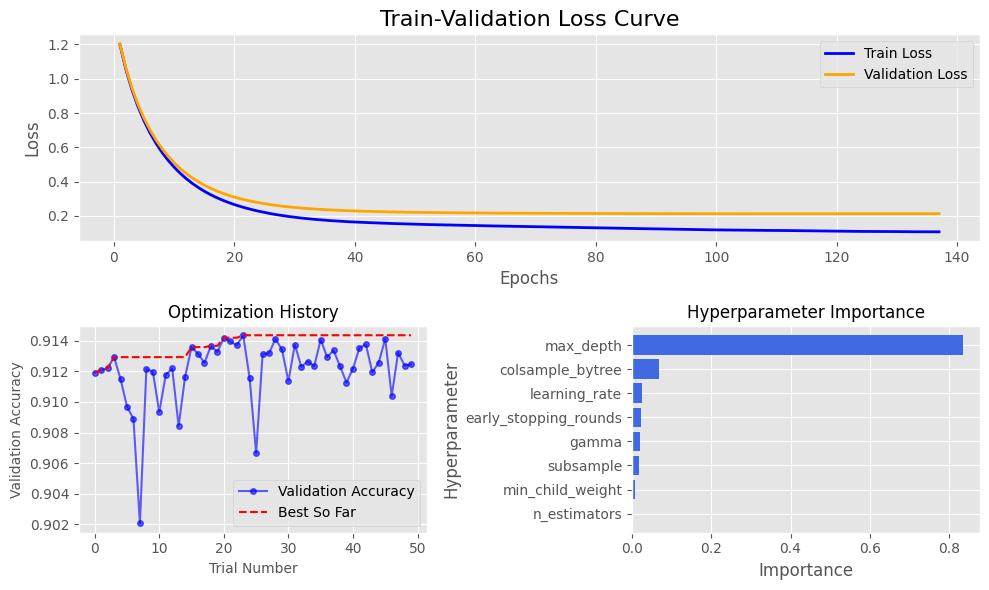

In [204]:
## 10. Plot Loss Curve, Train Optimization History, and Hyperparameter Importance          
plot_all(best_trial, study)

---

In [ ]:
# ######################################################
# #  ACF example                                       #
# ######################################################

# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_acf

# # ACF example plot for one random collection id
# def plot_acf_example(data):
#     random_collection_id = np.random.choice(data['collection_id'].unique(), 1, replace=False)
#     phase = data[data['collection_id'] == random_collection_id[0]]['phase']

#     plt.figure(figsize=(20, 3))
#     plot_acf(phase, lags=50)
    
#     plt.title(f'ACF Plot for Collection ID: {random_collection_id[0]}')
#     plt.xlabel('Lag')
#     plt.ylabel('Autocorrelation of phases')
#     plt.grid(True)
#     plt.show()

# plot_acf_example(scaled_data)

In [ ]:
# ######################################################
# # Plotting phase distribution per collection id    #
# ######################################################
# def plot_phase_levels(data):
#     """Plot phase levels by collection ID with class names."""
#     class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']

#     # Change column names in crosstab result to class_names
#     phase_levels = pd.crosstab(data['collection_id'], data['phase'])
#     phase_levels.columns = [class_names[col] for col in phase_levels.columns]  # Change numbers to class_names
#     print(phase_levels)

#     phase_levels.plot(kind='bar', stacked=True, figsize=(20, 10))

#     plt.title('Phase Levels by Collection ID ( preprocessed data )')
#     plt.xlabel('Collection ID')
#     plt.ylabel('Count')
#     plt.legend(title='Phase')
#     plt.tight_layout()  # Automatically adjust to prevent overlap of graph elements
#     plt.xticks([])
#     plt.show()

# # Call the function with scaled_data
# plot_phase_levels(scaled_data)